In [1]:
import pickle
from pathlib import Path

from tqdm.notebook import tqdm

import numpy as np

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
ls *pickle

specphot_phoenix.pickle


In [4]:
with open('specphot_phoenix.pickle', 'rb') as f:
    dct = pickle.load(f)
dct.keys()

dict_keys(['features', 'absmags'])

In [5]:
for k, v in dct.items():
    globals()[k] = v

In [6]:
absmags.keys()

dict_keys(['HST/ACS_WFC.F475W/Vega', 'HST/ACS_WFC.F555W/Vega', 'HST/ACS_WFC.F606W/Vega', 'HST/ACS_WFC.F814W/Vega', 'JWST/NIRCam.F070W/AB', 'JWST/NIRCam.F090W/AB', 'JWST/NIRCam.F115W/AB', 'JWST/NIRCam.F150W/AB', 'JWST/NIRCam.F200W/AB', 'SLOAN/SDSS.u/AB', 'SLOAN/SDSS.g/AB', 'SLOAN/SDSS.r/AB', 'SLOAN/SDSS.i/AB', 'SLOAN/SDSS.z/AB', 'Generic/Johnson.B/Vega', 'Generic/Johnson.V/Vega', 'Generic/Johnson.R/Vega', 'Generic/Johnson.I/Vega'])

In [7]:
featuresl = features.copy()
featuresl['logteff'] = np.log10(featuresl.pop('teff'))
featuresl

{'logg': array([4.5, 2.5, 2. , ..., 3.5, 5. , 3. ]),
 'fehish': array([-0.5,  1. ,  1. , ..., -1. , -1. , -0. ]),
 'logteff': array([3.92427929, 4.04921802, 3.73239376, ..., 3.94448267, 3.47712125,
        3.38021124])}

In [8]:
next(iter(featuresl.values())).shape, next(iter(absmags.values())).shape

((7508,), (7508,))

In [9]:
test_absmags = {k:v for k,v in absmags.items() if ('F814W' in k or 'F606W' in k)}
test_absmags.keys()

dict_keys(['HST/ACS_WFC.F606W/Vega', 'HST/ACS_WFC.F814W/Vega'])

# SVMs? 

In [10]:
from sklearn import svm

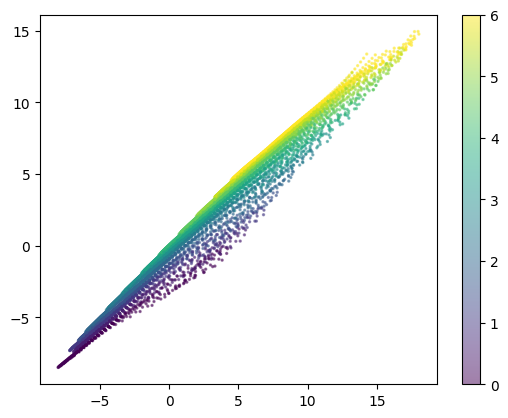

In [11]:
X = np.array(list(test_absmags.values()))
y = featuresl['logg']

plt.scatter(X[0], X[1], c=y, s= 2, alpha=.5)
plt.colorbar()

In [12]:
regr = svm.SVR()
regr.fit(X.T, y)

SVR()

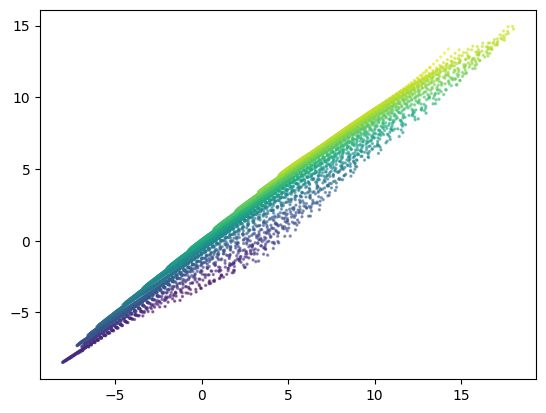

In [13]:
plt.scatter(X[0], X[1], c=regr.predict(X.T), s= 2, alpha=.5)

Hmm.  Simple enough it might work?

In [14]:
svms = {}

# this is the default, and it doesn't seem to do much better even trying the others...
kernel = 'rbf' # 'linear', 'poly', 'rbf', 'sigmoid'
degree = 3

for fnm, y in featuresl.items():
    svms[fnm] = regr = svm.SVR(kernel=kernel, degree=degree)
    regr.fit(X.T, y)

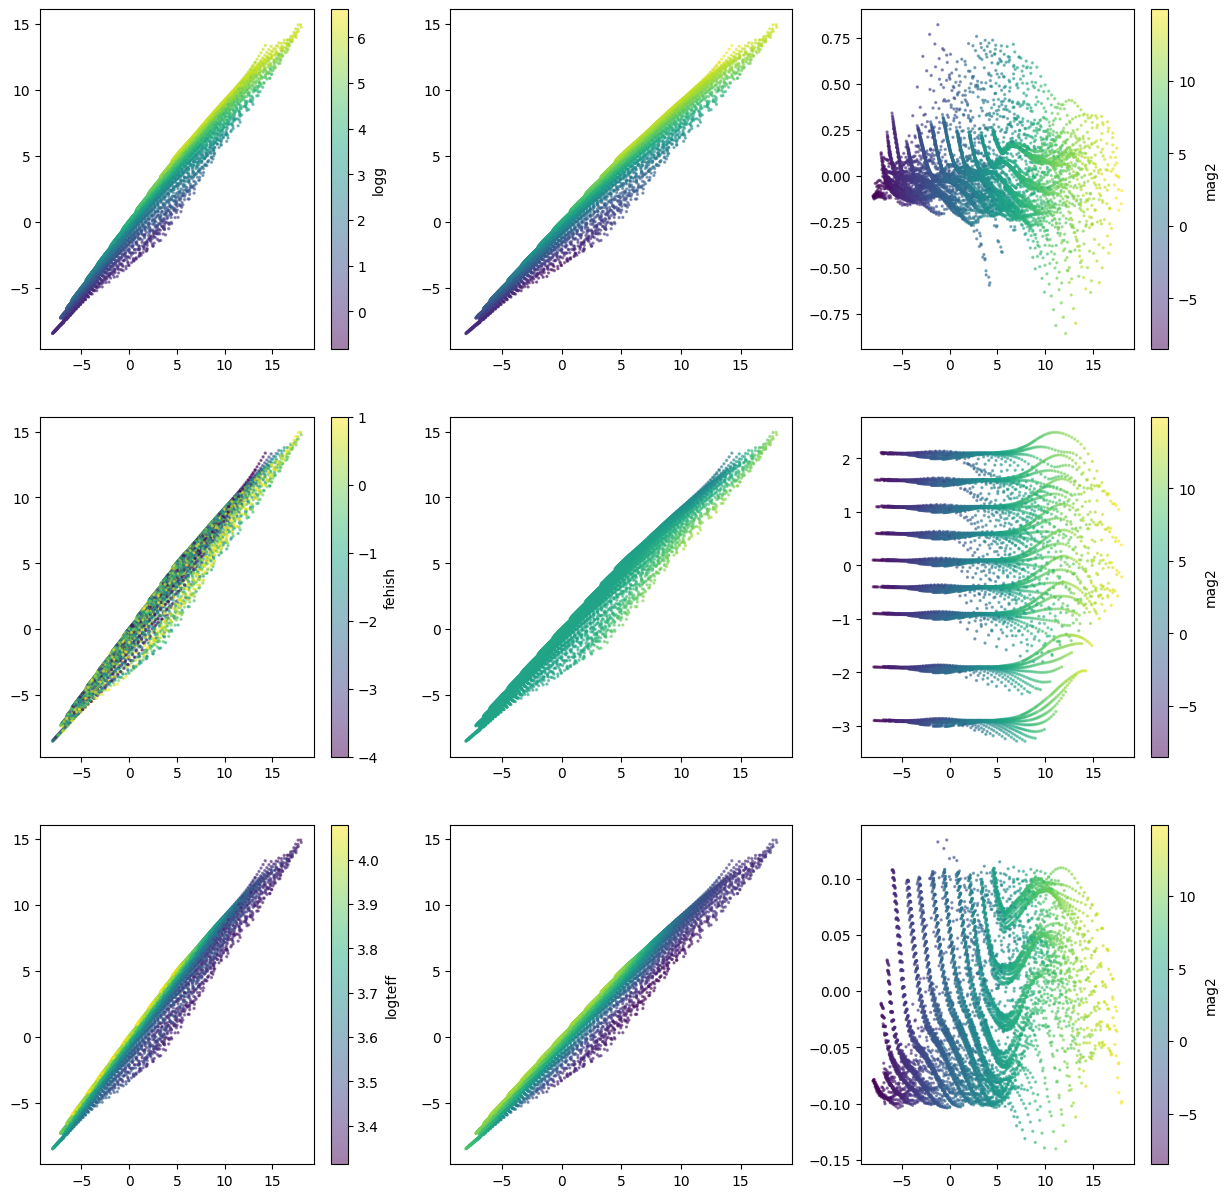

In [15]:
fig, axs = plt.subplots(len(svms), 3, figsize=(15, 15))

for (ax1, ax2, ax3), (fnm, regr) in zip(axs, svms.items()):
    y = featuresl[fnm]
    yp = regr.predict(X.T)

    mi = np.min(np.concatenate([y, yp]))
    mx = np.max(np.concatenate([y, yp]))

    sc1 = ax1.scatter(X[0], X[1], c=y, s=2, alpha=.5, vmin=mi, vmax=mx)
    sc2 = ax2.scatter(X[0], X[1], c=yp, s=2, alpha=.5, vmin=mi, vmax=mx)
    plt.colorbar(sc1).set_label(fnm)

    sc3 = ax3.scatter(X[0], y-yp, c=X[1], s=2, alpha=.5)
    plt.colorbar(sc3).set_label('mag2')

With any choice of kernel we still have this (unsurprising) problem that the Fe/H dependence is hard to capture.

## Gaussian Process?

In [16]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import *
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

X = np.array(list(test_absmags.values()))
y = featuresl['logg']


kernel = 1.0 * ExpSineSquared(1.0, 5.0, periodicity_bounds=(1e-2, 1e1))
kernel = 1 * RBF(length_scale=.1, length_scale_bounds=(1e-2, 1e2))
kernel = 1 * Matern(length_scale=.1, nu=1.5)

gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

pl = make_pipeline(StandardScaler(), gaussian_process)
pl = gaussian_process

sub = np.random.permutation(y.size)[:100]
pl.fit(X.T[sub], y[sub])

GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=0.1, nu=1.5),
                         n_restarts_optimizer=9)

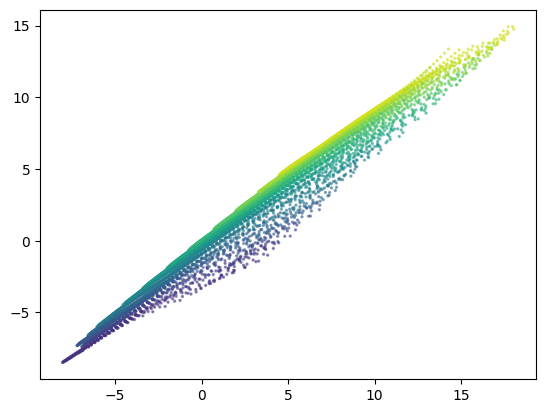

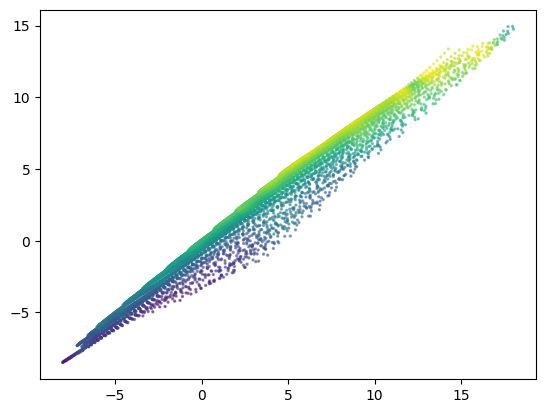

In [17]:
yp = pl.predict(X.T)

mi = np.min(np.concatenate([y, yp]))
mx = np.max(np.concatenate([y, yp]))

plt.scatter(X[0], X[1], c=y, s=2, alpha=.5, vmin=mi, vmax=mx)
plt.figure()
plt.scatter(X[0], X[1], c=yp, s=2, alpha=.5, vmin=mi, vmax=mx)

Hmm, it works but doesn't converge sometimes?

## Decision trees

In [18]:
from sklearn import tree


X = np.array(list(test_absmags.values()))
y = featuresl['logg']


In [19]:
dtree = tree.DecisionTreeRegressor(max_depth=None)


training_sub = np.random.permutation(y.size)[:100000]

dtree.fit(X.T[training_sub], y[training_sub])

DecisionTreeRegressor()

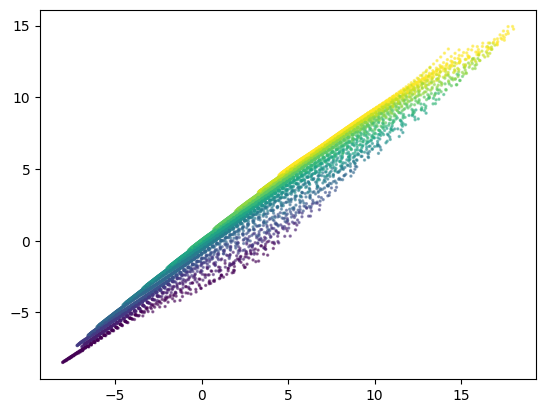

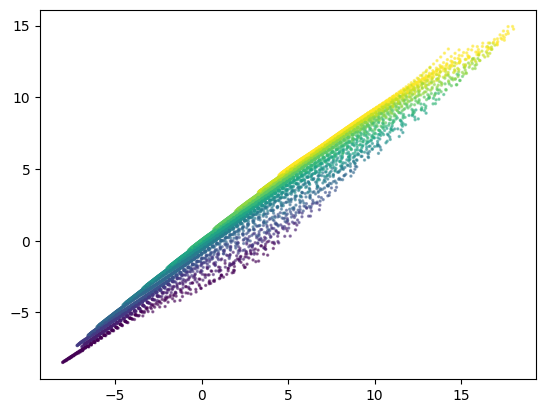

In [20]:
yp = dtree.predict(X.T)

mi = np.min(np.concatenate([y, yp]))
mx = np.max(np.concatenate([y, yp]))

plt.scatter(X[0], X[1], c=y, s=2, alpha=.5, vmin=mi, vmax=mx)
plt.figure()
plt.scatter(X[0], X[1], c=yp, s=2, alpha=.5, vmin=mi, vmax=mx)

multioutput?

In [21]:
yall = np.array(list(featuresl.values()))

In [22]:
mtree = tree.DecisionTreeRegressor(max_depth=None)

training_sub = np.random.permutation(y.size)[:500]

mtree.fit(X.T[training_sub], yall.T[training_sub])

DecisionTreeRegressor()

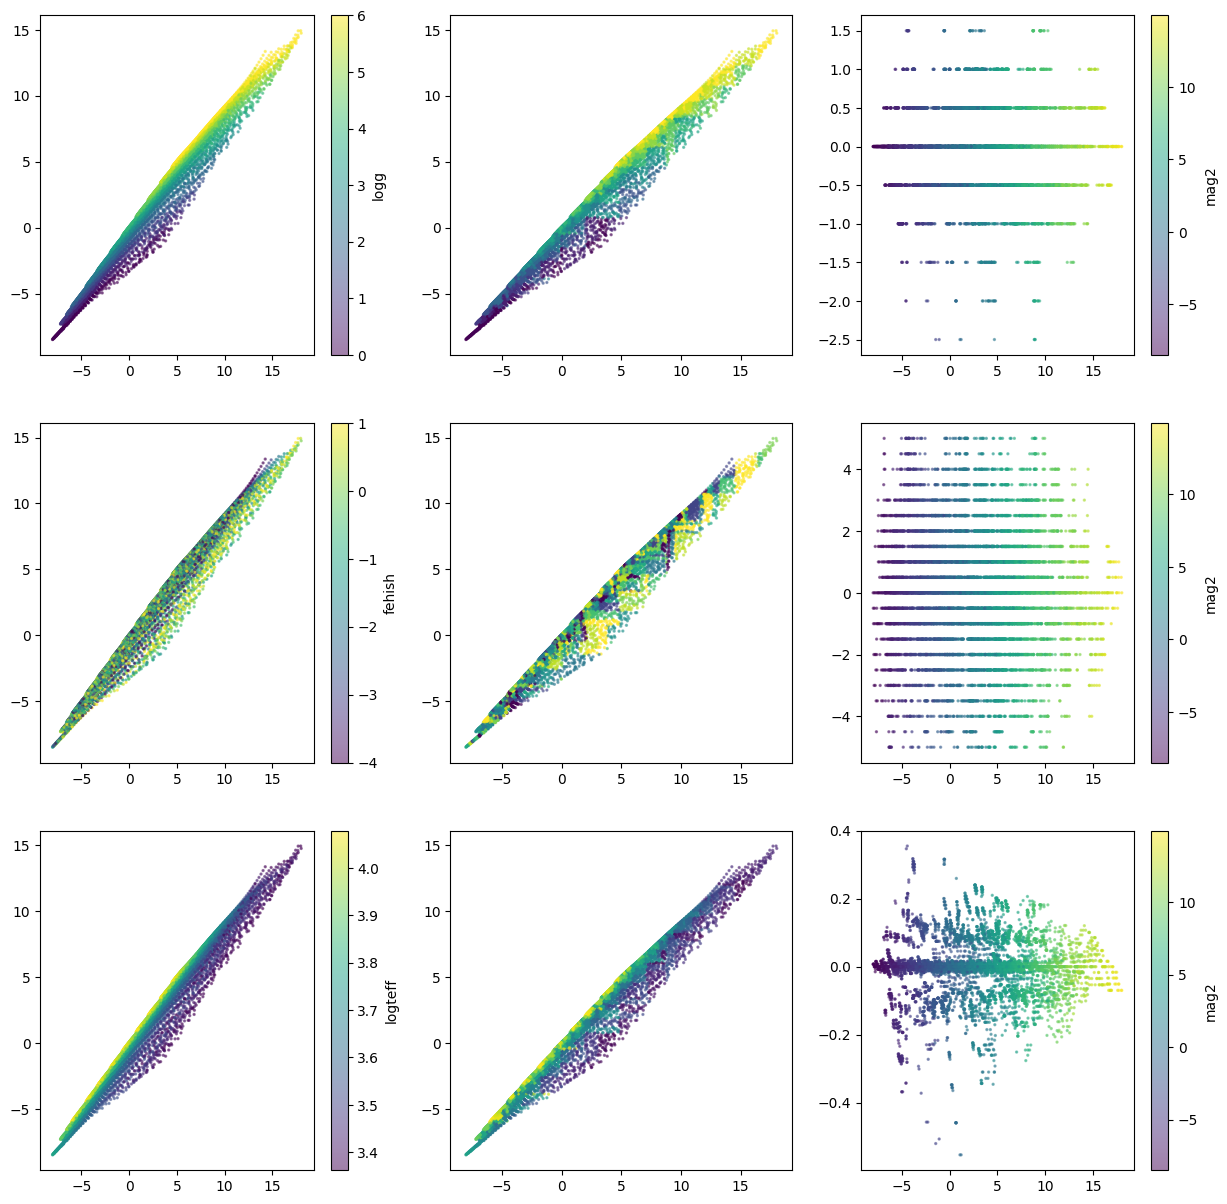

In [23]:
yp = mtree.predict(X.T)

fig, axs = plt.subplots(len(svms), 3, figsize=(15, 15))

for (ax1, ax2, ax3), (fnm, f), fyp in zip(axs, featuresl.items(), yp.T):
    y = featuresl[fnm]

    mi = np.min(np.concatenate([y, fyp]))
    mx = np.max(np.concatenate([y, fyp]))

    sc1 = ax1.scatter(X[0], X[1], c=y, s=2, alpha=.5, vmin=mi, vmax=mx)
    sc2 = ax2.scatter(X[0], X[1], c=fyp, s=2, alpha=.5, vmin=mi, vmax=mx)
    plt.colorbar(sc1).set_label(fnm)

    sc3 = ax3.scatter(X[0], y-fyp, c=X[1], s=2, alpha=.5)
    plt.colorbar(sc3).set_label('mag2')

In [24]:
from sklearn import ensemble

In [25]:
forest = ensemble.RandomForestRegressor()

training_sub = np.random.permutation(y.size)[:250000]

forest.fit(X.T[training_sub], yall.T[training_sub])

RandomForestRegressor()

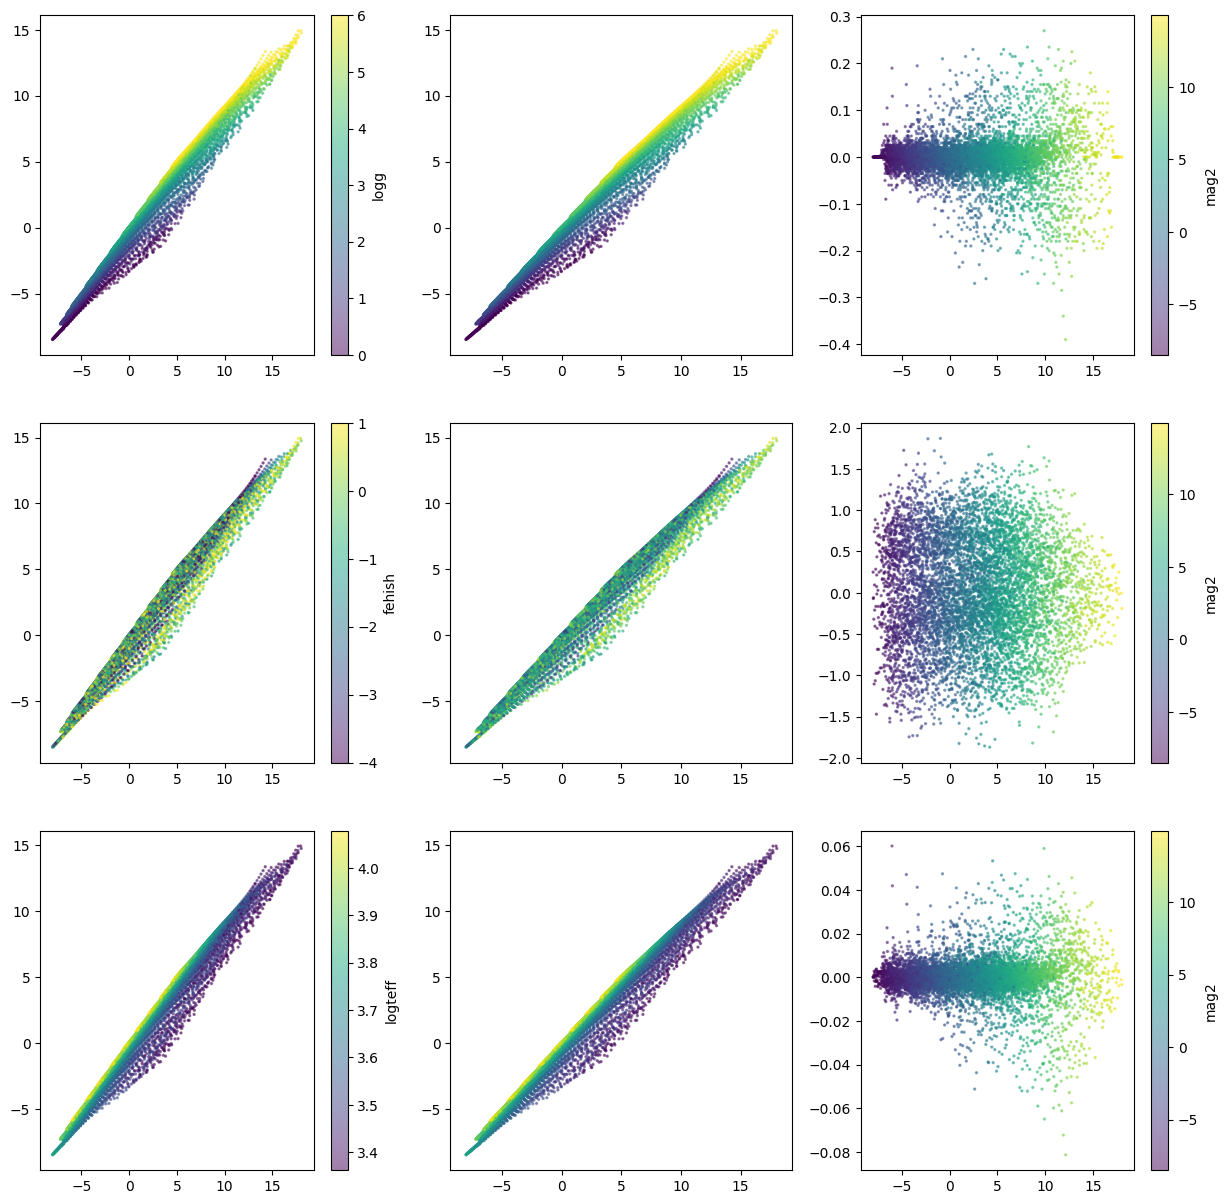

In [26]:
yp = forest.predict(X.T)

fig, axs = plt.subplots(len(svms), 3, figsize=(15, 15))

for (ax1, ax2, ax3), (fnm, f), fyp in zip(axs, featuresl.items(), yp.T):
    y = featuresl[fnm]

    mi = np.min(np.concatenate([y, fyp]))
    mx = np.max(np.concatenate([y, fyp]))

    sc1 = ax1.scatter(X[0], X[1], c=y, s=2, alpha=.5, vmin=mi, vmax=mx)
    sc2 = ax2.scatter(X[0], X[1], c=fyp, s=2, alpha=.5, vmin=mi, vmax=mx)
    plt.colorbar(sc1).set_label(fnm)

    sc3 = ax3.scatter(X[0], y-fyp, c=X[1], s=2, alpha=.5)
    plt.colorbar(sc3).set_label('mag2')

Kinda works but still really fails to handle metalicity well.

# GPyTorch

First follow the basic tutorial at https://tinygp.readthedocs.io/en/stable/tutorials/intro.html to try to fit just one of the parameters

In [27]:
import torch

torch_device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {torch_device} device")

import gpytorch

Using cuda device


In [28]:
X = torch.from_numpy(np.array(list(test_absmags.values()))).T.to(torch_device, dtype=torch.float32)
y0_raw = torch.from_numpy(featuresl['logg']).to(torch_device, dtype=torch.float32)

y0offset = y0_raw.min()
y0scale = y0_raw.max() - y0offset
y0 = (y0_raw - y0offset)/y0scale

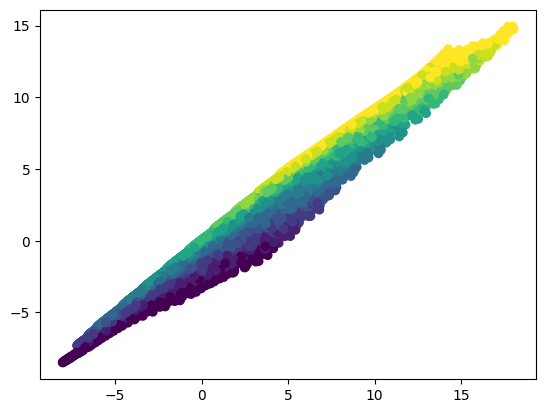

In [29]:
plt.scatter(X[:, 0].cpu(), X[:, 1].cpu(), c=y0.cpu())

In [30]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=train_x.shape[-1]))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

    def train(self, *args, **kwargs):
        super().train(*args, **kwargs)
        self.likelihood.train(*args, **kwargs)

    def eval(self, *args, **kwargs):
        super().eval(*args, **kwargs)
        self.likelihood.eval(*args, **kwargs)


  0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 2.0927529335021973 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.033951997756958 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG termin

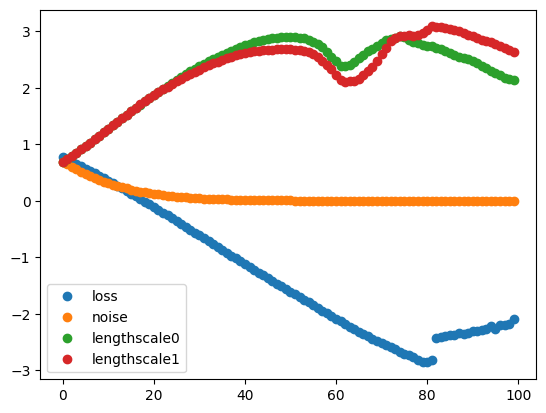

In [31]:
likelihood = gpytorch.likelihoods.GaussianLikelihood().to(torch_device)
model = ExactGPModel(X, y0, likelihood).to(torch_device)

model.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.1) 

mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model).to(torch_device)


fits = []
t = tqdm(range(100))
for i in t:
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(X)
    # Calc loss and backprop gradients
    loss = -mll(output, y0)
    loss.backward()
    
    fits.append([loss.item(), model.likelihood.noise.item()])
    for ls in model.covar_module.base_kernel.lengthscale.cpu().detach().numpy()[0]:
        fits[-1].append(ls)

    t.set_description(f'loss={loss}')
    t.refresh()
    
    optimizer.step()
    
labels = ['loss', 'noise']
labels.extend([f'lengthscale{i}' for i in range(len(fits[0])-2)])
plt.plot(fits, 'o', label=labels)
plt.legend(loc=0);

Why does it go crazy at the end?? Well, lets limit to something that's less weird.

  0%|          | 0/75 [00:00<?, ?it/s]

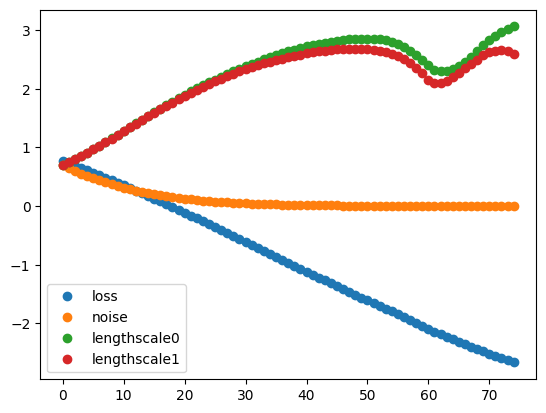

In [32]:
likelihood = gpytorch.likelihoods.GaussianLikelihood().to(torch_device)
model = ExactGPModel(X, y0, likelihood).to(torch_device)

model.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.1) 

mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model).to(torch_device)


fits = []
t = tqdm(range(75))
for i in t:
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(X)
    # Calc loss and backprop gradients
    loss = -mll(output, y0)
    loss.backward()
    
    fits.append([loss.item(), model.likelihood.noise.item()])
    for ls in model.covar_module.base_kernel.lengthscale.cpu().detach().numpy()[0]:
        fits[-1].append(ls)

    t.set_description(f'loss={loss}')
    t.refresh()
    
    optimizer.step()
    
labels = ['loss', 'noise']
labels.extend([f'lengthscale{i}' for i in range(len(fits[0])-2)])
plt.plot(fits, 'o', label=labels)
plt.legend(loc=0);

/usr/local/lib/python3.11/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


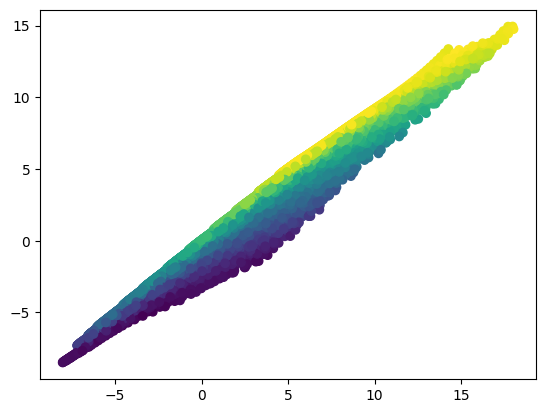

In [33]:
model.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(X))
    
    plt.scatter(X[:, 0].cpu(), X[:, 1].cpu(), c=observed_pred.mean.cpu())

Huzzah! Now lets try dividing into training and validation sets.

In [34]:
validation_fraction = .5
nvalid = int(X.shape[0]*validation_fraction)

idxs = np.random.permutation(X.shape[0])
X_test = X[idxs[:nvalid]]
y0_test = y0[idxs[:nvalid]]

X_train = X[idxs[nvalid:]]
y0_train = y0[idxs[nvalid:]]

  0%|          | 0/75 [00:00<?, ?it/s]

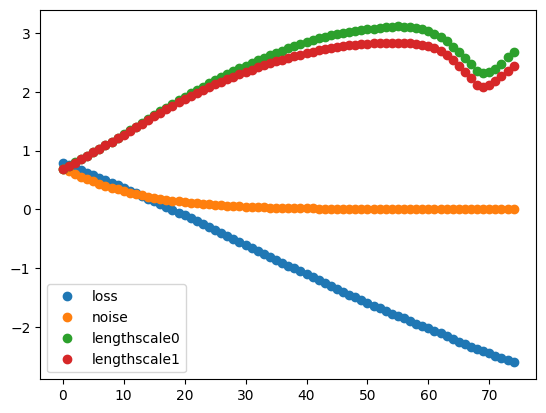

In [35]:
likelihood = gpytorch.likelihoods.GaussianLikelihood().to(torch_device)
model = ExactGPModel(X_train, y0_train, likelihood).to(torch_device)

model.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.1) 

mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model).to(torch_device)


fits = []
t = tqdm(range(75))
for i in t:
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(X_train)
    # Calc loss and backprop gradients
    loss = -mll(output, y0_train)
    loss.backward()
    
    fits.append([loss.item(), model.likelihood.noise.item()])
    for ls in model.covar_module.base_kernel.lengthscale.cpu().detach().numpy()[0]:
        fits[-1].append(ls)

    t.set_description(f'loss={loss}')
    t.refresh()
    
    optimizer.step()
    
labels = ['loss', 'noise']
labels.extend([f'lengthscale{i}' for i in range(len(fits[0])-2)])
plt.plot(fits, 'o', label=labels)
plt.legend(loc=0)

model.eval()

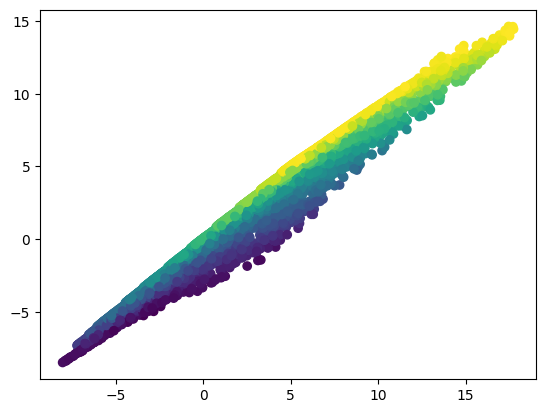

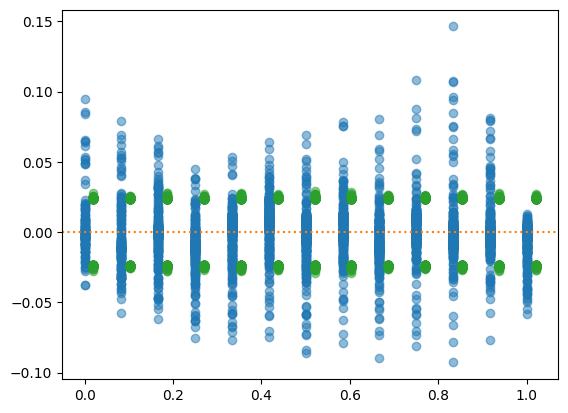

In [36]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(X_train))
    
    plt.scatter(X_train[:, 0].cpu(), X_train[:, 1].cpu(), c=observed_pred.mean.cpu())
    
    plt.figure()
    plt.scatter(y0_train.cpu(), observed_pred.mean.cpu() - y0_train.cpu(), alpha=.5)
    plt.scatter(y0_test.cpu()+.02, observed_pred.stddev.cpu(), c='C2', alpha=.5)
    plt.scatter(y0_test.cpu()+.02, -observed_pred.stddev.cpu(), c='C2', alpha=.5)
    
plt.axhline(0, c='C1', ls=':');

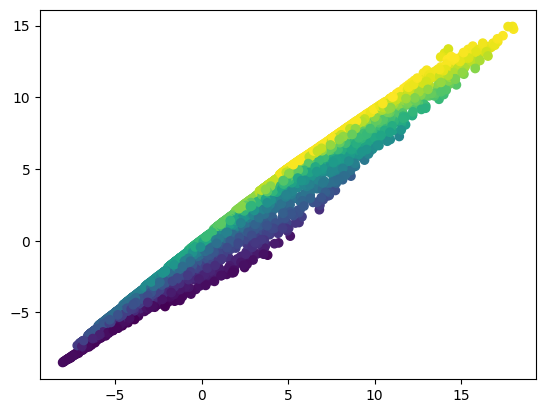

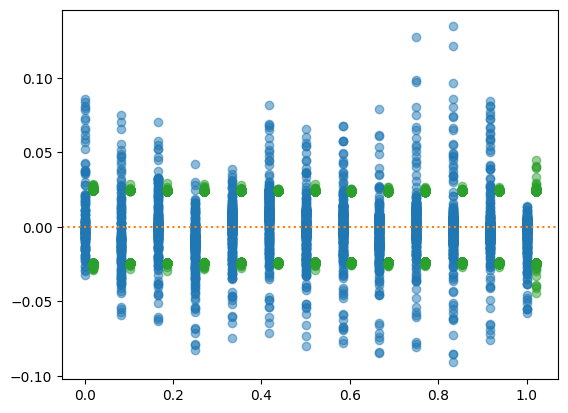

In [37]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(X_test))
    
    plt.scatter(X_test[:, 0].cpu(), X_test[:, 1].cpu(), c=observed_pred.mean.cpu())

    plt.figure()
    plt.scatter(y0_test.cpu(), observed_pred.mean.cpu() - y0_test.cpu(), alpha=.5)
    plt.scatter(y0_test.cpu()+.02, observed_pred.stddev.cpu(), c='C2', alpha=.5)
    plt.scatter(y0_test.cpu()+.02, -observed_pred.stddev.cpu(), c='C2', alpha=.5)

plt.axhline(0, c='C1', ls=':');

What about the multi-output approach?

In [134]:
X = torch.from_numpy(np.array(list(test_absmags.values()))).T.to(torch_device, dtype=torch.float32)

y3_raw = torch.from_numpy(np.array(list(featuresl.values()))).to(torch_device, dtype=torch.float32).T

y3offset = y3_raw.min(0).values
y3scale = y3_raw.max(0).values - y3offset
y3 = (y3_raw - y3offset[np.newaxis, :])/y3scale[np.newaxis, :]

In [135]:
validation_fraction = .5
nvalid = int(X.shape[0]*validation_fraction)

idxs = np.random.permutation(X.shape[0])
X_test = X[idxs[:nvalid]]
y3_test = y3[idxs[:nvalid]]

X_train = X[idxs[nvalid:]]
y3_train = y3[idxs[nvalid:]]

In [136]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=3
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.RBFKernel(ard_num_dims=train_x.shape[-1]), num_tasks=3, rank=2
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

    def train(self, *args, **kwargs):
        super().train(*args, **kwargs)
        self.likelihood.train(*args, **kwargs)

    def eval(self, *args, **kwargs):
        super().eval(*args, **kwargs)
        self.likelihood.eval(*args, **kwargs)


  0%|          | 0/75 [00:00<?, ?it/s]

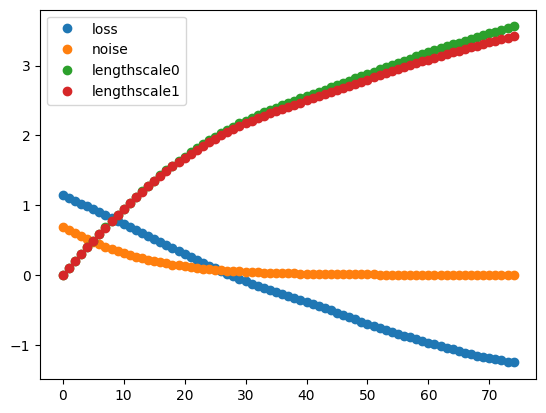

In [137]:
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=3).to(torch_device)
model = MultitaskGPModel(X_train, y3_train, likelihood).to(torch_device)

model.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.1) 

mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model).to(torch_device)


fits = []
t = tqdm(range(75))
for i in t:
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(X_train)
    # Calc loss and backprop gradients
    loss = -mll(output, y3_train)
    loss.backward()
    
    fits.append([loss.item(), model.likelihood.noise.item()])
    for ls in model.covar_module.data_covar_module.raw_lengthscale.cpu().detach().numpy()[0]:
        fits[-1].append(ls)

    t.set_description(f'loss={loss}')
    t.refresh()
    
    optimizer.step()
    
labels = ['loss', 'noise']
labels.extend([f'lengthscale{i}' for i in range(len(fits[0])-2)])
plt.plot(fits, 'o', label=labels)
plt.legend(loc=0)

In [155]:
model.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(X_test)) 

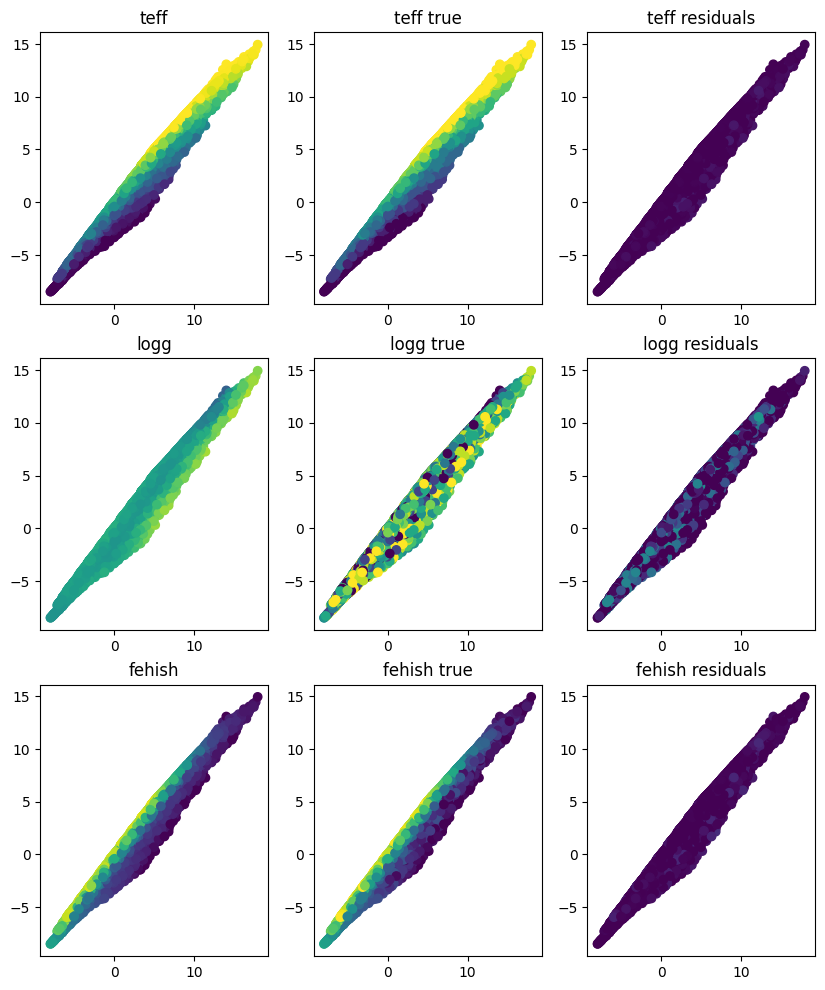

In [144]:
fig, axs = plt.subplots(3, 3, figsize=(10, 12))

for (ax1, ax2, ax3), i, fnm in zip(axs, range(3), features.keys()):
    ax1.scatter(X_test[:, 0].cpu(), X_test[:, 1].cpu(), c=observed_pred.mean[:,i].cpu(), vmin=0, vmax=1)
    ax1.set_title(fnm)
    
    ax2.scatter(X_test[:, 0].cpu(), X_test[:, 1].cpu(), c=y3_test[:,i].cpu(), vmin=0, vmax=1)
    ax2.set_title(fnm + ' true')
    
    ax3.scatter(X_test[:, 0].cpu(), X_test[:, 1].cpu(), c=(y3_test[:,i]-observed_pred.mean[:,i]).cpu(), vmin=0, vmax=1)
    ax3.set_title(fnm + ' residuals')

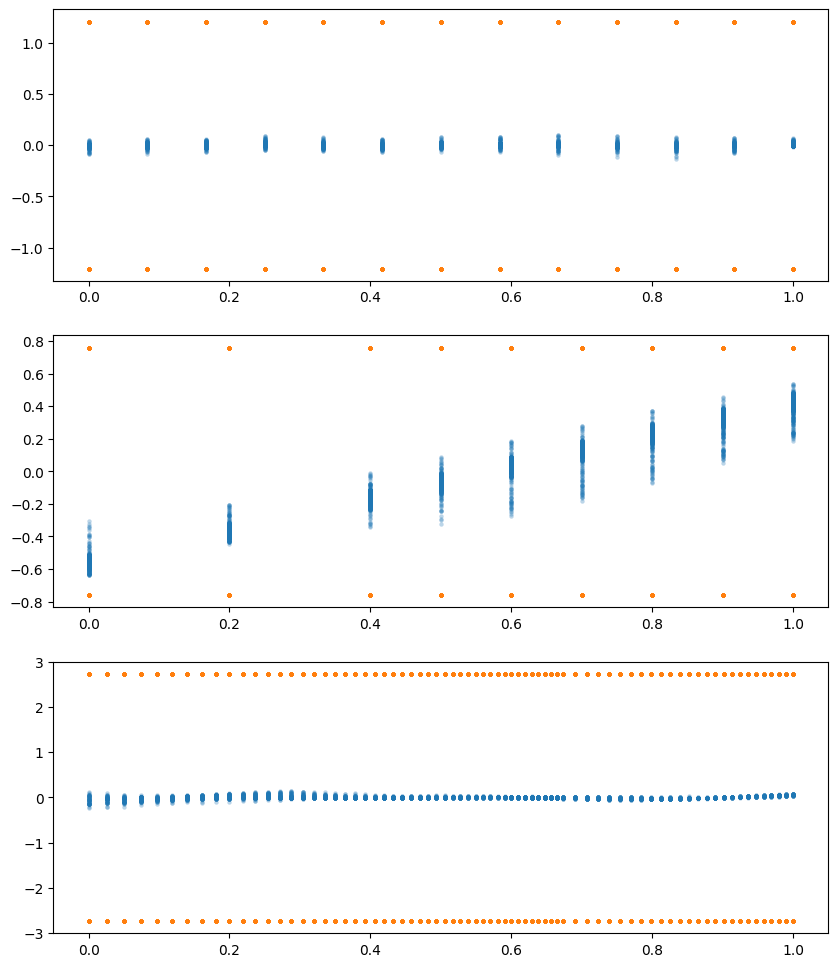

In [178]:
fig, axs = plt.subplots(3, 1, figsize=(10, 12))

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    for ax, i, fnm in zip(axs, range(3), features.keys()):
        ax.scatter(y3_test[:,i].cpu(), (y3_test[:,i]- observed_pred.mean[:,i]).cpu(), label=fnm, alpha=.3, lw=0, s=10, c='C0')
        ax.scatter(y3_test[:,i].cpu(), + observed_pred.stddev[:,i].cpu(), label=fnm, alpha=.3, lw=0, s=10, c='C1')
        ax.scatter(y3_test[:,i].cpu(), - observed_pred.stddev[:,i].cpu(), label=fnm, alpha=.3, lw=0, s=10, c='C1')

In [177]:
observed_pred.covariance_matrix[2::3, 1::3].shape

torch.Size([3754, 3754])